In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.integrate as integrate
import statistics
from sklearn.linear_model import LinearRegression
import numpy.linalg
from sympy import *

## Exercise 1

Define probability density function of Gaussian distribution

In [2]:
def gaussian(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*((x-sigma)/sigma)**2)

a) Composite trapezoidal rule:

In [3]:
def trapezoidal(f, x0, xN, N):
    h = (xN-x0) / N
    summ = 0.5 * (f(x0) + f(xN))
    
    #h-refinement
    for i in range(1,N):
        summ += f(x0 + i*h)
    return h*summ

b) Composite Simpson’s rule:

In [4]:
def simpson (f, x0, xN, N):
    h = (xN-x0) / N
    summ = (1/6) * (f(x0) + f(xN))
    
    #h- and p-refinement
    for i in range(1,N):
        summ += (1/3) * f(x0 + i*h)

    for i in range(1,N+1):
        summ += (2/3) * f(((x0 + (i-1)*h)+(x0 + i*h))/2)

    return h*summ

Integral calculations:

In [5]:
#define variables
mu = 3
sigma = 2
x0 = 0
xN = 5
N = 10
f = lambda x: gaussian(x, mu, sigma)


In [6]:
#Trapezoidal:
trapezoidal(f, x0, xN, N)

0.7722620004615055

In [7]:
#Simpson
simpson(f, x0, xN, N)

0.7745384012739794

Bonus #1: composite midepoint rule:

In [8]:
N=10

def midpoint(f, x0, xN, N):
    summ = 0
    h = (xN-x0) / N
    for i in range(1,N+1):
        summ += f(x0 + (i-0.5)*h)
    return h*summ
midpoint(f, x0, xN, N)

0.7756766016802167

Bonus #2: Monte carlo:

In [9]:
#define function with choosing random points, define mean function value f(x)
N=10
def montecarlo(f, x0, xN, N):
    summ = 0
    h = (xN-x0) / N
    for i in range(1,N+1):
        xi = np.random.uniform(low=0, high=5)
        summ += f(xi)
    return h*summ
montecarlo(f, x0, xN, N)

0.7927778249574395

Plot convergence order

In [10]:
#calculate "exact" result of Gaussian
P_exact = scipy.integrate.quad(f, 0, 5)
P_exact = P_exact[0]
P_exact

0.7745375447996848

In [11]:
#Repeat plot:

#define variables
N_values = np.logspace(start=0, stop=7, base=10, num=15, dtype=int)

error_simpson = []
error_trapezoidal = []
error_montecarlo = []
error_midpoint = []

#loop over N to calculate rel. errors
for N in N_values:
    x = np.linspace(x0, xN, N+1)
    
    #calculate different approximations of the integral
    P_N_montecarlo = montecarlo(f, x0, xN, N)
    P_N_simpson = simpson(f, x0, xN, N)
    P_N_trapezoidal = trapezoidal(f, x0, xN, N)
    P_N_midpoint = midpoint(f, x0, xN, N)

    
    #calculate relative error
    error_montecarlo.append(abs((P_N_montecarlo - P_exact) / P_exact))
    error_simpson.append(abs((P_N_simpson - P_exact) / P_exact))
    error_trapezoidal.append(abs((P_N_trapezoidal - P_exact) / P_exact))
    error_midpoint.append(abs((P_N_midpoint - P_exact) / P_exact))
    


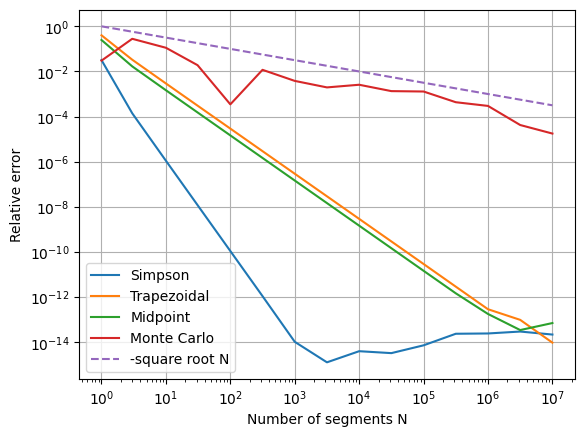

In [12]:
 #plot all 4
plt.loglog(N_values, error_simpson, label='Simpson')
plt.loglog(N_values, error_trapezoidal, label='Trapezoidal')
plt.loglog(N_values, error_midpoint, label='Midpoint')
plt.loglog(N_values, error_montecarlo, label='Monte Carlo')
plt.loglog(N_values, N_values**(-0.5), '--', label='-square root N')

plt.xlabel('Number of segments N')
plt.ylabel('Relative error')
plt.legend()
plt.grid()
plt.show()

Convergence order calculations:

In [41]:
##Linear regression:
#set x and y
x = np.array(np.log(N_values).reshape((-1, 1)))
y_midpoint = np.log(error_midpoint)
y_trapezoidal = np.log(error_trapezoidal)
y_simpson = np.log(error_simpson)
y_montecarlo = np.log(error_montecarlo)
y_root_N = np.log(N_values**(-0.5))

#perform linear regression
reg_midpoint = LinearRegression().fit(x, y_midpoint)
reg_trapezoidal = LinearRegression().fit(x, y_trapezoidal)
reg_simpson = LinearRegression().fit(x[0:6], y_simpson[0:6])
reg_montecarlo = LinearRegression().fit(x, y_montecarlo)
reg_root_N = LinearRegression().fit(x, y_root_N)

#get slopes:
print(f"Convergence orders:\nMidpoint: {-reg_midpoint.coef_}\nTrapezoidal: {-reg_trapezoidal.coef_}\nSimpson: {-reg_simpson.coef_}\nMontecarlo: {-reg_montecarlo.coef_}\nSquare root N: {-reg_root_N.coef_}")

Convergence orders:
Midpoint: [1.90874074]
Trapezoidal: [1.95917343]
Simpson: [4.13258301]
Montecarlo: [0.46640433]
Square root N: [0.5]


## Exercise 2

In [37]:
alpha=100
beta=4
gamma=20
delta=0.01

solution = np.array([[gamma/delta],[alpha/beta]])

R,F=symbols('R F')
X = Matrix([R, F])
f_x = Matrix([alpha*R-beta*R*F, -gamma*F+delta*R*F])

x_0=np.array([[1000.0],[100.0]])

tol_x=0.1

J=f_x.jacobian(X)

J_inv=J.inv()

xi = [x_0]
error_i = []
error_current_step = []
error_previous_step =[]

def l2_norm(x,y=0):
    
    norm=np.sqrt(float(np.sum(np.array(x-y)**2)))
    
    return norm

def compute_next_x(intial_x, inverse_jacobian,f_of_x):
    
    next_x=intial_x-inverse_jacobian.subs([(R, intial_x[0,0]), (F,intial_x[1,0])])*f_of_x.subs([(R, intial_x[0,0]), (F,intial_x[1,0])])
    
    xi.append(next_x)
    error = l2_norm(intial_x,next_x)
    error_i.append(error)
    error_current_step.append(l2_norm(next_x,solution)/l2_norm(solution))
    error_previous_step.append(l2_norm(intial_x,solution)/l2_norm(solution))
    
    return next_x

def NR_method(f_of_x, inverse_jacobian, intial_x, tolerance):
    
    next_x=compute_next_x(intial_x, inverse_jacobian, f_of_x)

    absolute=np.array(abs(intial_x-next_x))
    
    if np.sum(absolute<tolerance)==2:
        
        return next_x
    
    else:
        
        return NR_method(f_of_x, inverse_jacobian, next_x, tolerance)
    
steady_state=np.array(NR_method(f_x, J_inv, x_0, tol_x))
steady_state

array([[2000.00000000000],
       [25.0000000000000]], dtype=object)

In [38]:
f_x.subs([(R,steady_state[0,0]),(F,steady_state[1,0])])

Matrix([
[-2.91038304567337e-11],
[ 8.88178419700125e-14]])

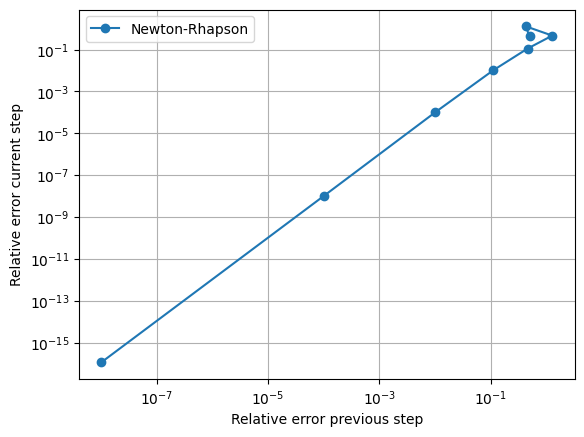

In [42]:
#Convergence plot
plt.loglog(error_previous_step, error_current_step, 'o-', label='Newton-Rhapson')
plt.xlabel('Relative error previous step')
plt.ylabel('Relative error current step')
plt.legend()
plt.grid()
plt.show()

In [40]:
#Linear regression to get slope
##Linear regression:
#set x and y
x = np.array(np.log(error_previous_step[:-1]).reshape((-1, 1)))
y = np.array(np.log(error_current_step[:-1]))

#perform linear regression
reg_newton = LinearRegression().fit(x, y)

#get slopes:
print(f"Convergence order Newton-Rhapson = {reg_newton.coef_}")

Convergence order Newton-Rhapson = [1.99323776]
